In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
!pip install tensorflow
!pip install pandas
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import os
import math
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


2024-01-25 11:49:36.945257: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 11:49:36.945601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 11:49:37.125788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 11:49:37.477513: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-25 11:49:39.717331: W tensorflow/compiler/tf2

# Class to Discretise MDP from env

In [2]:
class MDP:
    def __init__(self, env):
        self.env = env
        self.df_discrete = None
        self.df_MDP = None
        
    def generateSample(self, episodes=1000, max_episode_length=2000, noise = 0):
        state_size = self.env.observation_space.shape[0]
        samples = []
        for episode in range(episodes):
            state = self.env.reset()[0]
            episode_length = 0

            while episode_length <= max_episode_length:
                action = self.env.action_space.sample()
                next_state, reward, done, _, _ = self.env.step(action)
                state = list(state)
                action = [str(action)]
                reward = [reward]
                next_state = list(next_state)
                #next_state = [noise*random.uniform(-1, 1)+next_state[i] for i in range(state_size)]
                next_state = self.add_noise(next_state)

                sample = state + action + reward + next_state
                samples.append(sample)
                state = next_state
                
                episode_length += 1
                if done:
                    break
                    
        df = pd.DataFrame(samples)
        df.columns = [f'variable_{i}' for i in range(state_size)] + ['action','reward'] + [f'nx_variable_{i}' for i in range(state_size)]
        self.df_data = df
    
    def discretizeFromBins(self, bins): #bins - list
        state_var = []
        nx_state_var = []
        for i in range(len(bins)):
            col_name = 'variable_' + str(i)
            col_name_nx = 'nx_' + col_name
            non_null_values_col, non_null_values_col_nx = self.df_data[col_name].dropna(), self.df_data[col_name_nx].dropna()
            state_var.append(col_name)
            nx_state_var.append(col_name_nx)
            if bins[i] > 1:
                min_value, max_value = self.min_max_states(non_null_values_col, non_null_values_col_nx)
                bin_size = (max_value - min_value) / bins[i]
                bin = [min_value + i * bin_size for i in range(bins[i] + 1)]
                self.df_data[col_name] = pd.cut(non_null_values_col, bins=bins[i], labels=False) + 1
                self.df_data[col_name_nx] = pd.cut(non_null_values_col_nx, bins=bins[i], labels=False) + 1
        self.df_discrete = pd.DataFrame(self.df_data['action'])
        self.df_discrete['current_state'] = self.df_data.loc[:, state_var].apply(lambda row: ', '.join(map(str, row)), axis=1)
        self.df_discrete['next_state'] = self.df_data.loc[:, nx_state_var].apply(lambda row: ', '.join(map(str, row)), axis=1)
    
    #Discretizes the MDPs based on json file.
    #df_MDP - MDP formed from the original data, df_discrete - Discretized MDP formed based on json file.
    def discretizeFromJSON(self, jsonFile):
        df_json = pd.read_json(jsonFile)
        self.state_var = []
        self.nx_state_var = []
        self.state_bin_var = []
        self.nx_state_bin_var = []
        self.df_MDP = self.df_data.copy()
        
        for i, row in df_json.iterrows():
            col_name, col_name_nx, col_name_bins, col_name_bins_nx = self.naming_state_col(row['column_name'])
            non_null_values_col, non_null_values_col_nx = self.df_data[col_name].dropna(), self.df_data[col_name_nx].dropna()
            self.state_var.append(col_name)
            self.nx_state_var.append(col_name_nx)
            self.state_bin_var.append(col_name_bins)
            self.nx_state_bin_var.append(col_name_bins_nx)

            if row['no_of_bins'] is not None and not math.isnan(row['no_of_bins']):
                bins = int(row['no_of_bins'])
                min_value, max_value = self.min_max_states(non_null_values_col, non_null_values_col_nx)
                bin_size = (max_value - min_value) / bins
                bin = [min_value + i * bin_size for i in range(bins + 1)]
                self.df_MDP[col_name_bins] = pd.cut(non_null_values_col, bins=bins, labels=False) + 1
                self.df_MDP[col_name_bins_nx] = pd.cut(non_null_values_col_nx, bins=bins, labels=False) + 1

            elif row['bin_size'] is not None and not math.isnan(row['bin_size']):
                bin_size = row['bin_size']
                min_value, max_value = self.min_max_states(non_null_values_col, non_null_values_col_nx)
                bin = [min_value + i * bin_size for i in range(bins + 1)]
                self.df_MDP[col_name_bins] = pd.cut(non_null_values_col, bins=bins, labels=False) + 1
                self.df_MDP[col_name_bins_nx] = pd.cut(non_null_values_col_nx, bins=bins, labels=False) + 1

            elif len(row['bin_list'])>0:
                bin_list = row['bin_list']
                if isinstance(bin_list, list):
                    bin_list = [interval for interval in bin_list if all(not math.isnan(value) for value in interval)]
                if bin_list:
                    bin_intervals = [interval[0] for interval in bin_list] + [bin_list[-1][-1]]
                    self.df_MDP[col_name_bins] = pd.cut(non_null_values_col, bins=bins, labels=False) + 1
                    self.df_MDP[col_name_bins_nx] = pd.cut(non_null_values_col_nx, bins=bins, labels=False) + 1
                    
        self.df_MDP['current_state'] = self.df_MDP.loc[:, self.state_var].apply(lambda row: ', '.join(map(str, row)), axis=1)
        self.df_MDP['next_state'] = self.df_MDP.loc[:, self.nx_state_var].apply(lambda row: ', '.join(map(str, row)), axis=1)
        
        self.df_MDP['current_state_bin'] = self.df_MDP.loc[:, self.state_bin_var].apply(lambda row: ', '.join(map(str, row)), axis=1)
        self.df_MDP['next_state_bin'] = self.df_MDP.loc[:, self.nx_state_bin_var].apply(lambda row: ', '.join(map(str, row)), axis=1)
           
        self.df_MDP = self.df_MDP[['current_state','next_state','current_state_bin','next_state_bin','action','reward']]

        new_column_names = {'current_state_bin' : 'current_state' , 'next_state_bin' : 'next_state'}
        self.df_discrete = pd.DataFrame(self.df_MDP[['current_state_bin','next_state_bin','action','reward']].rename(columns=new_column_names))
        #print(self.df_discrete.columns)
    
    #Constructs MDP from the discretised features
    def constructMDPfromDiscreteFeature(self, output_file = None):
        if self.df_discrete is None:
            print("Data is not discretised")
            return
        self.discrete_MDP = self.constructMDPforDF(self.df_discrete, output_file)
        
    #Construct MDP from the original state features (Not discretised)    
    def constructMDP(self, output_file = None):
        self.df_MDP = self.constructMDPforDF(self.df_MDP, output_file)
    
    #Constructs and returns the MDP for a provided dataframe and stores in excel
    def constructMDPforDF(self, df, output_file):
        #Discretized Sample to MDP
        df_empirical_probs = df.groupby(['current_state', 'action', 'next_state']).size().reset_index(name='count')
        df_empirical_count = df.groupby(['current_state', 'action']).size().reset_index(name='count_total')

        df_empirical_probs = df_empirical_probs.merge(df_empirical_count, on=['current_state', 'action'])
        df_empirical_probs['probability'] = df_empirical_probs['count'] / df_empirical_probs['count_total']
 
        
        if output_file is not None:
            df_empirical_probs[['current_state', 'action', 'next_state', 'probability']].to_excel(output_file, index=False)
        return df_empirical_probs[['current_state', 'action', 'next_state', 'probability']]
        
    #Returns Minimum and Maximum value of a state feature
    def min_max_states(self, non_null_values_col, non_null_values_col_nx):
        return min(non_null_values_col.min(),non_null_values_col_nx.min()), max(non_null_values_col.max(),non_null_values_col_nx.max())
    
    #Naming convention for column names
    def naming_state_col(self, col_name):
        return col_name,'nx_' + col_name, col_name + '_bins','nx_' + col_name + '_bins'
    
    def verification(self):
        #print(self.df_MDP)
        print(self.discrete_MDP)
        
    def visualize_MDP_networkx(self, save_path = None):
        if self.df_MDP is None:
            return
        else:
            self.visualize_discreteMDP_networkx(self.df_MDP, save_path = save_path)
            
    def add_noise(self, state):
        # Add noise to the next state
        noisy_state = state + np.random.normal(loc=0, scale=0.1, size=state.shape)  # You can adjust the scale of noise as needed
        return noisy_state
        
    def visualize_discreteMDP_networkx(self, df = None, save_path = None):
        if df is None:
            df = self.discrete_MDP
        
        #Display the MDP
        mdp_graph = nx.DiGraph()

        states = set(df['current_state']) | set(df['next_state'])

        # Add states as nodes to the graph
        for state in states: 
            mdp_graph.add_node(state)

        # Add transitions as edges to the graph
        for index, row in df.iterrows():
            state = row['current_state']  
            action = row['action']
            next_state = row['next_state']  
            probability = format(row['probability'],".2f") 
            mdp_graph.add_edge(state, next_state, label=f'{action} ({probability})')

        # Plot the MDP graph
        pos = nx.kamada_kawai_layout(mdp_graph)
        labels = nx.get_edge_attributes(mdp_graph, 'label')
        plt.figure(figsize=(9, 9))  # Adjust figure size as needed
        nx.draw_networkx(mdp_graph, pos, with_labels=True, node_size=500, node_color='lightblue')
        nx.draw_networkx_edge_labels(mdp_graph, pos, edge_labels=labels)
        plt.title("MDP Graph")
        plt.axis('off')
        if save_path:
            plt.savefig(save_path, format="png")
        else:
            plt.show()
        
    def visualize_discreteMDP_graphviz(self, df = None): 
        if df is None:
            df = self.discrete_MDP
            
        df['current_state'] = df['current_state'].astype(str)
        df['next_state'] = df['next_state'].astype(str)
        df['action'] = df['action'].astype(str)
        df['probability'] = df['probability'].astype(float)
        
        graph = graphviz.Digraph(format='png',
            node_attr={
                'shape': 'circle',
                'style': 'filled',
                'fillcolor': 'lightblue',
                'fontsize': '12',
                'fontcolor': 'black',
                'width': '0.3',
                'height': '0.3',
            },
            edge_attr={
                'fontsize': '10',
                'fontcolor': 'gray',
                'arrowhead': 'normal',
                'arrowsize': '0.5',
            },
            graph_attr={
                'rankdir': 'LR',
                'splines': 'true',
                'nodesep': '0.6',
                'ranksep': '0.8',
                'dpi': '300',
            })

        # Add nodes
        states = df['current_state'].unique().tolist() + df['next_state'].unique().tolist()
        for state in states:
            graph.node(state)

        # Add edges
        for _, row in df.iterrows():
            edge_label = f"{row['action']} ({round(row['probability'], 4)})"
            graph.edge(row['current_state'], row['next_state'], label=edge_label)

        # Render and display the graph
        graph.render('mdp_graph', view=True)   

In [3]:
# Initialize CartPole environment
#env_name = 'CartPole-v1'
#env_name = 'MountainCarContinuous-v0'
#env_name = 'MountainCar-v0'
env_name = 'Pendulum-v1'
env = gym.make(env_name)
mdp = MDP(env)
mdp.generateSample(max_episode_length = 200, noise = 0)

/home/jeeva/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


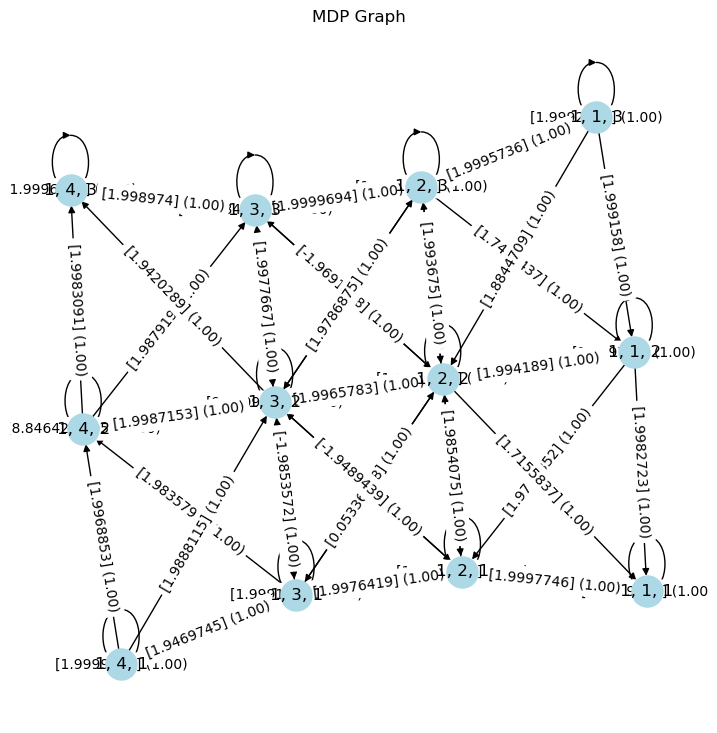

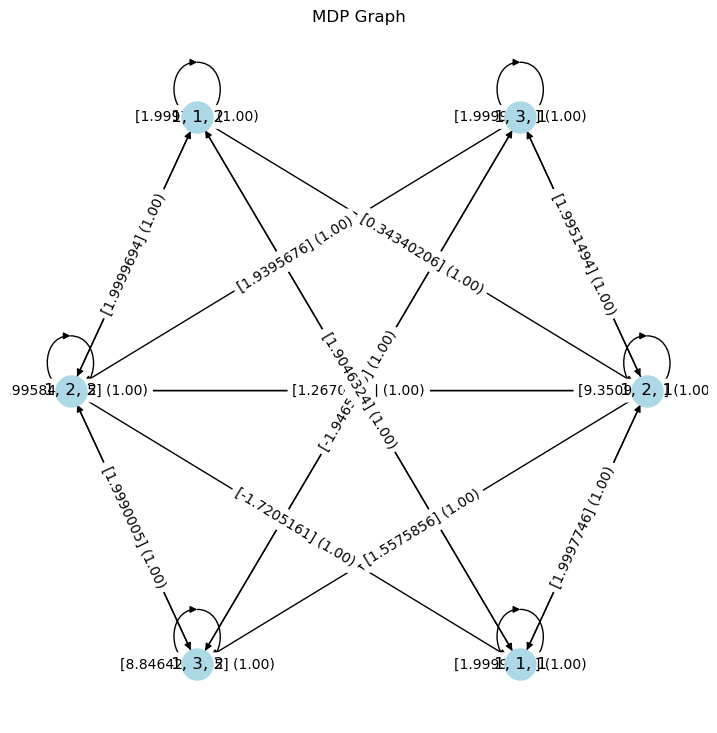

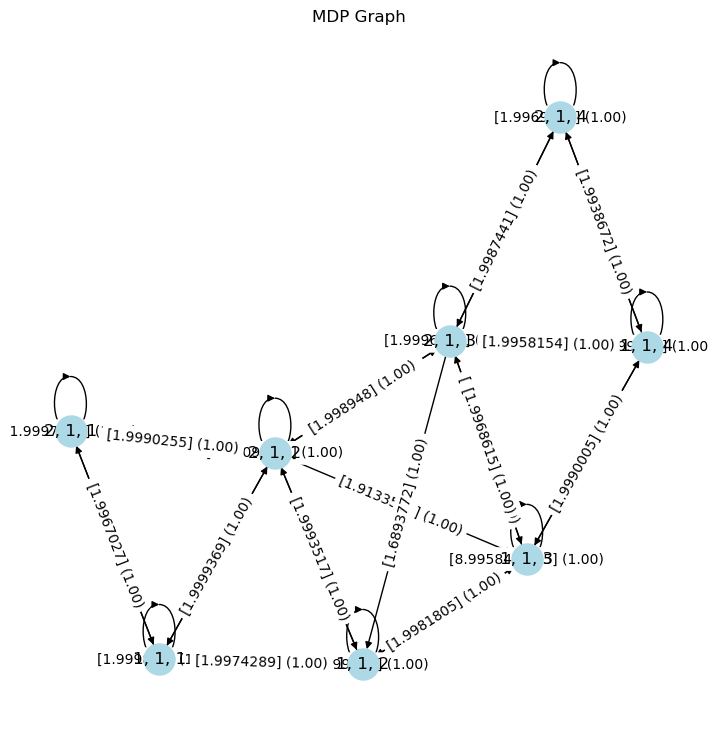

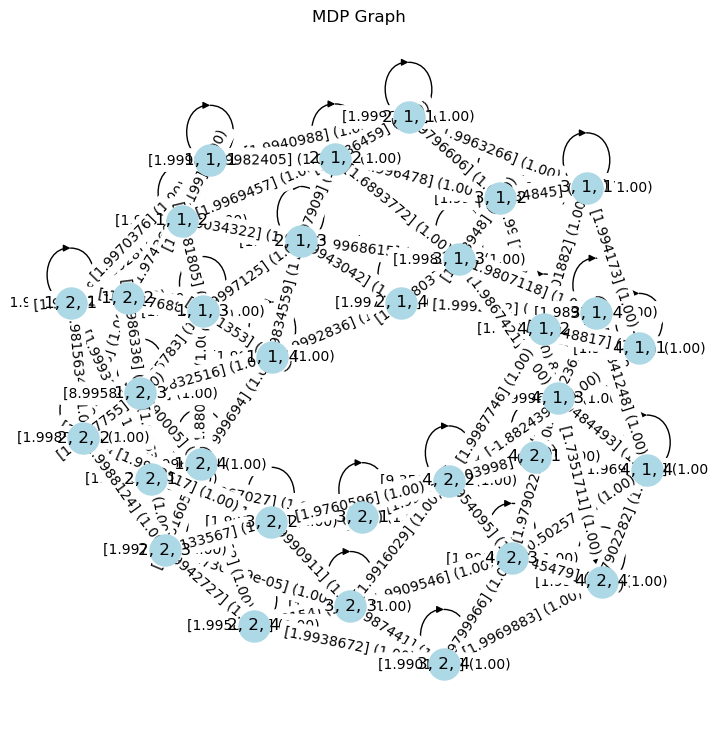

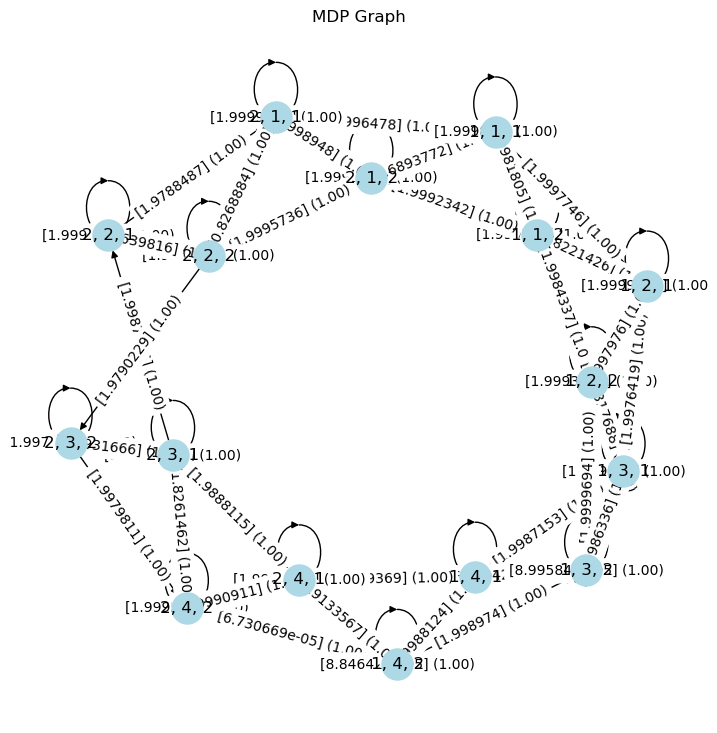

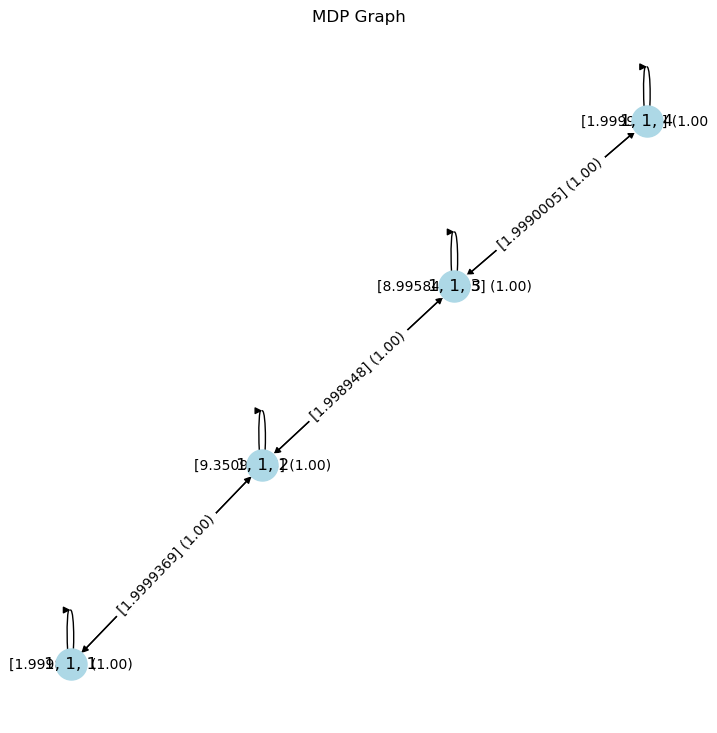

In [4]:

state_size = env.observation_space.shape[0]

#Create Multiple discretisations
for k in range(6):
    #data - json format for descritisatio definition.
    data = '[\n'
    
    #choose random bin size for all state varibles
    bins = [ random.randint(1,4) for i in range(state_size)]

    for i in range(state_size):
        if i != 0:
            data += ',\n'
        data += '{\n\t"column_name": "variable_' + str(i) + '" ,\n\t"no_of_bins": ' + str(bins[i]) + '\n}'

    data += '\n]'

    #print(data)

    json_filename = env_name + "_discretebins_" + str(bins) + ".json"
    discreteMDP_filename = env_name + "_discretebins_" + str(bins) + ".xlsx"
    image_discreteMDP_filename = env_name + "_discretebins_" + str(bins) + ".png"

    if not os.path.exists(json_filename):
        with open(json_filename, 'w') as file:
            file.write(data)
            
    mdp.discretizeFromJSON(json_filename)
    mdp.constructMDPfromDiscreteFeature(discreteMDP_filename)
    mdp.visualize_discreteMDP_networkx(save_path = image_discreteMDP_filename)

#Store the Original MDP
MDP_filename = env_name + ".xlsx"
image_discreteMDP_filename = env_name + ".png"
mdp.constructMDP(MDP_filename)
#mdp.visualize_MDP_networkx(save_path = image_discreteMDP_filename)

In [ ]:
# Initialize CartPole environment
env_name = 'CartPole-v1'
env = gym.make(env_name)
mdp = MDP(env)
mdp.generateSample()
mdp.discretizeFromBins([2,2,2,2])
mdp.constructMDPfromDiscreteFeature()
mdp.verification()

In [ ]:
# Initialize CartPole environment
env = gym.make('MountainCarContinuous-v0')
mdp = MDP(env)
mdp.generateSample(100,10)
mdp.discretizeFromBins([2,2])
mdp.constructMDPfromDiscreteFeature()
mdp.verification()

In [ ]:
# Initialize CartPole environment
env = gym.make('MountainCar-v0')
mdp = MDP(env)
mdp.generateSample(100,10)
mdp.discretizeFromBins([2,2])
mdp.constructMDPfromDiscreteFeature()
mdp.verification()

In [ ]:
env = gym.make('Pendulum-v1', g=9.81)
mdp = MDP(env)
mdp.generateSample(100,10)
mdp.discretizeFromBins([2,2,4])
mdp.constructMDPfromDiscreteFeature()
mdp.verification()